This notebook contains code that is good enough for demonstration purposes here, not fully tested code ready for real use.

In [1]:
# Set some notebook defaults
ENV["COLUMNS"] = 1000; ENV["LINES"] = 20;

# Display information about the environment
VERSION, Base.Threads.nthreads(), Base.Sys.CPU_THREADS

(v"1.5.3", 8, 8)

In [2]:
using Random, Distributions, BenchmarkTools, Tullio, LoopVectorization, DataFrames, StaticKernels, SantasLittleHelpers
using RollingFunctions, ThreadsX, Plots, Statistics

In [3]:
w_size = 15 # window size for rolling average
N = 10^8
d = Normal()
df = DataFrame(:data => rand(d, N))
# df = DataFrame(data = ones(N))

,data
,Float64
1,-0.513138
2,-0.201272
3,-0.0298583
4,2.10579
5,0.112803
6,0.308425
7,-0.503107
8,0.249407
9,-1.04437


In [4]:
df[!, "sma_rf"] = runmean(df.data, w_size)
df

,data,sma_rf
,Float64,Float64
1,-0.513138,-0.513138
2,-0.201272,-0.357205
3,-0.0298583,-0.248089
4,2.10579,0.340381
5,0.112803,0.294865
6,0.308425,0.297125
7,-0.503107,0.182807
8,0.249407,0.191132
9,-1.04437,0.0538533


In [5]:
# Calculate sma using StaticKernels and SantasLittleHelpers
# Contains code originally from Tyler Beason

k = makekernel(mean,-w_size+1:0)
df[!, "sma_sk"] = applyrolling(k, df.data)
df

,data,sma_rf,sma_sk
,Float64,Float64,Float64
1,-0.513138,-0.513138,-0.513138
2,-0.201272,-0.357205,-0.357205
3,-0.0298583,-0.248089,-0.248089
4,2.10579,0.340381,0.340381
5,0.112803,0.294865,0.294865
6,0.308425,0.297125,0.297125
7,-0.503107,0.182807,0.182807
8,0.249407,0.191132,0.191132
9,-1.04437,0.0538533,0.0538533


In [6]:
# Contains code originally from Michael Abbott

tmp = Array{Union{Missing, Float64}}(missing, length(df.data));

function f_tullio(data, sma, window_size)
    rate = 1/window_size
    out_view = @view sma[window_size:end]
    @tullio out_view[i] = rate*data[i+o]  o in 0:window_size-1  # verbose=true;
    sma
end

df[!, "sma_tullio"] = f_tullio(df.data, tmp, w_size)
df

,data,sma_rf,sma_sk,sma_tullio
,Float64,Float64,Float64,Float64?
1,-0.513138,-0.513138,-0.513138,missing
2,-0.201272,-0.357205,-0.357205,missing
3,-0.0298583,-0.248089,-0.248089,missing
4,2.10579,0.340381,0.340381,missing
5,0.112803,0.294865,0.294865,missing
6,0.308425,0.297125,0.297125,missing
7,-0.503107,0.182807,0.182807,missing
8,0.249407,0.191132,0.191132,missing
9,-1.04437,0.0538533,0.0538533,missing


In [7]:
# Contains code originally from Peter Deffebach

out = Vector{Union{Missing, Float64}}(undef, N)

function rollingmean_simd(x, m, out)
    N = length(x)
    out[1:(m-1)] .= missing
    sm = mean(@view x[1:m])
    out[m] = sm
    @inbounds @simd for i in (m+1):length(x)
        sm += (x[i] - x[i-m]) / m
        out[i] = sm
    end
    return out 
end

rollingmean_simd (generic function with 1 method)

In [8]:
df[!, "sma_simd"] = rollingmean_simd(df.data, w_size, out)
df

,data,sma_rf,sma_sk,sma_tullio,sma_simd
,Float64,Float64,Float64,Float64?,Float64?
1,-0.513138,-0.513138,-0.513138,missing,missing
2,-0.201272,-0.357205,-0.357205,missing,missing
3,-0.0298583,-0.248089,-0.248089,missing,missing
4,2.10579,0.340381,0.340381,missing,missing
5,0.112803,0.294865,0.294865,missing,missing
6,0.308425,0.297125,0.297125,missing,missing
7,-0.503107,0.182807,0.182807,missing,missing
8,0.249407,0.191132,0.191132,missing,missing
9,-1.04437,0.0538533,0.0538533,missing,missing


In [9]:
function rolling_average(v; window_size::Int=10)
    @assert window_size > 0
    loffset = window_size ÷ 2
    roffset = loffset + window_size%2
    ThreadsX.map(eachindex(v)) do i
        mean(@view v[max(begin, i-loffset) : min(end, i+roffset)])
    end
end

rolling_average (generic function with 1 method)

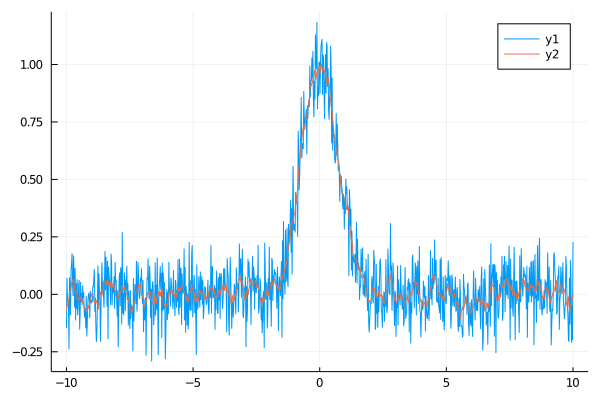

In [10]:
let xs = range(-10, 10, length=1000)
    ys = @. exp(-xs^2) + randn()/10
    plot(xs, ys)
    plot!(xs, rolling_average(ys))
end

In [11]:
df[!, "sma_tx"] = rolling_average(df.data, window_size=w_size)
df

,data,sma_rf,sma_sk,sma_tullio,sma_simd,sma_tx
,Float64,Float64,Float64,Float64?,Float64?,Float64
1,-0.513138,-0.513138,-0.513138,missing,missing,0.0538533
2,-0.201272,-0.357205,-0.357205,missing,missing,-0.0509144
3,-0.0298583,-0.248089,-0.248089,missing,missing,-0.176198
4,2.10579,0.340381,0.340381,missing,missing,-0.0971262
5,0.112803,0.294865,0.294865,missing,missing,-0.118687
6,0.308425,0.297125,0.297125,missing,missing,-0.259856
7,-0.503107,0.182807,0.182807,missing,missing,-0.366361
8,0.249407,0.191132,0.191132,missing,missing,-0.3869
9,-1.04437,0.0538533,0.0538533,missing,missing,-0.246777


In [12]:
df.sma_rf[w_size:end] ≈ df.sma_sk[w_size:end]

true

In [13]:
df.sma_rf[w_size:end] ≈ df.sma_tullio[w_size:end]

true

In [14]:
df.sma_rf[w_size:end] ≈ df.sma_simd[w_size:end]

true

In [15]:
df.sma_rf[w_size:end] ≈ df.sma_tx[w_size:end]

false

In [16]:
@benchmark runmean(df.data, w_size)

BenchmarkTools.Trial: 
  memory estimate:  1.49 GiB
  allocs estimate:  6
  --------------
  minimum time:     2.148 s (0.18% GC)
  median time:      2.239 s (2.92% GC)
  mean time:        2.253 s (4.11% GC)
  maximum time:     2.372 s (8.79% GC)
  --------------
  samples:          3
  evals/sample:     1

In [17]:
k = makekernel(mean,-w_size+1:0)
@benchmark applyrolling(k, df.data)

BenchmarkTools.Trial: 
  memory estimate:  762.94 MiB
  allocs estimate:  2
  --------------
  minimum time:     1.211 s (0.16% GC)
  median time:      1.247 s (0.16% GC)
  mean time:        1.278 s (3.82% GC)
  maximum time:     1.407 s (12.46% GC)
  --------------
  samples:          5
  evals/sample:     1

In [18]:
@benchmark f_tullio(df.data, tmp, w_size)

BenchmarkTools.Trial: 
  memory estimate:  8.13 KiB
  allocs estimate:  128
  --------------
  minimum time:     185.453 ms (0.00% GC)
  median time:      203.037 ms (0.00% GC)
  mean time:        202.764 ms (0.00% GC)
  maximum time:     218.298 ms (0.00% GC)
  --------------
  samples:          25
  evals/sample:     1

In [19]:
@benchmark rollingmean_simd(df.data, w_size, out)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     120.998 ms (0.00% GC)
  median time:      126.539 ms (0.00% GC)
  mean time:        126.856 ms (0.00% GC)
  maximum time:     135.113 ms (0.00% GC)
  --------------
  samples:          40
  evals/sample:     1

In [20]:
@benchmark rolling_average(df.data, window_size=w_size)

BenchmarkTools.Trial: 
  memory estimate:  1.77 GiB
  allocs estimate:  3963
  --------------
  minimum time:     2.562 s (12.01% GC)
  median time:      2.830 s (17.83% GC)
  mean time:        2.830 s (17.83% GC)
  maximum time:     3.098 s (22.64% GC)
  --------------
  samples:          2
  evals/sample:     1

In [21]:
using Random, Distributions, BenchmarkTools, RollingFunctions, ThreadsX, DataFrames
function rolling_average(v; window_size::Int=10)
    @assert window_size > 0
    loffset = window_size ÷ 2
    roffset = loffset + window_size%2
    ThreadsX.map(eachindex(v)) do i
        mean(@view v[max(begin, i-loffset) : min(end, i+roffset)])
    end
end
N = 1000
d = Normal()
df = DataFrame(:data => rand(d, N))
df[!, "runmean"] = @btime runmean(df.data, 10)
df[!, "rolling_average"] = @btime rolling_average(df.data, window_size=10)
df.runmean[10:end] ≈ df.rolling_average[10:end]

  14.128 μs (4 allocations: 16.13 KiB)
  88.016 μs (2852 allocations: 215.78 KiB)


false

In [22]:
df

,data,runmean,rolling_average
,Float64,Float64,Float64
1,-0.292673,-0.292673,-0.196465
2,0.91721,0.312269,-0.224377
3,-0.737441,-0.0376346,-0.102296
4,-0.70624,-0.204786,0.00578898
5,-0.0777992,-0.179389,-0.0979281
6,-0.281845,-0.196465,-0.187079
7,-0.391849,-0.224377,-0.124183
8,0.752269,-0.102296,-0.218671
9,0.870468,0.00578898,-0.350731
